# Osteosarcoma Classification Model 
Data-Set: https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=52756935#52756935171ba531fc374829b21d3647e95f532c

Author: Arsh Goenka

Before you start - Go into CSV files with annotations and remove multiple of the same annotation in Training Set 1 (Set 2 & Set 8), and for Training Set 2 (Set 9 & Set 12, as well as all the zanotated annotations in every set).

# Imports

In [6]:
### Run this cell to import the packages you will need to unpack the dataset
# File manipulation and IO (input/output)
import os
import pickle
import zipfile

# Import numerical and dataframe handling
import numpy as np
import scipy
import pandas as pd

# Data preprocessing
from PIL import Image
from sklearn.utils import shuffle

# Model scoring
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Import standard machine learning machinery
import tensorflow as tf

# Garbage collection (for saving RAM during training)
import gc

# Import plotting functionality
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import matplotlib

from skimage import transform

In [7]:
# Set plotting preferences
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

# Data Pre-Processing

## Read Files

In [8]:
import glob

#Read CSV Files
search_dir = 'Osteosarcoma-UT'

csv_paths = []

for filename in glob.iglob(search_dir + '**/**', recursive=True):
    if filename[-4:] == '.csv':
        csv_paths.append(filename)
        
csv_paths
dataframes_list = []
for csv_filename in csv_paths:
    df_object = pd.read_csv(csv_filename,header=None,index_col=False)
    dataframes_list.append(df_object)


In [9]:
#Read CSV File into df and create compatible img name
full_df = pd.concat(dataframes_list, ignore_index=True)
full_df.rename(columns = {0:'img_num', 1:'label'}, inplace=True)

char19 = []
for img_num in full_df['img_num']:
    img_num_new = img_num[-14:]
    char19.append(img_num_new)

full_df.insert(1,"name",char19,True)

full_df

,img_num,name,label
0,Case 3 A10-28110-17616.jpg,8110-17616.jpg,Non-Viable-Tumor
1,Case 3 A10-26546-21577.jpg,6546-21577.jpg,Non-Viable-Tumor
2,Case 3 A10-37695-6276.jpg,37695-6276.jpg,Non-Viable-Tumor
3,Case 3 A13-26388-12521.jpg,6388-12521.jpg,Non-Viable-Tumor
4,Case 3 A13-29731-5963.jpg,29731-5963.jpg,Non-Viable-Tumor
...,...,...,...
1139,Case 48 - P5 C22-25507-14943.jpg,5507-14943.jpg,Viable
1140,Case 48 - P5 C21-19402-23915.jpg,9402-23915.jpg,Non-Tumor
1141,Case 48 - P5 C20-28430-29841.jpg,8430-29841.jpg,Non-Tumor
1142,Case 48 - P5 C21-36006-23109.jpg,6006-23109.jpg,Viable


In [10]:
#Initialize variables
images = np.zeros((1144, 1024, 1024, 3), dtype = np.uint8)
new_label = []
directory = 'Osteosarcoma-UT'

count = 0

#Read files and put into correct variables
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    for set_file in os.listdir(f):
        g = os.path.join(f, set_file)
        for img in os.listdir(g):
            pimg = os.path.join(g, img)
            if(img == 'PathologistValidation.csv'):
                   pass
            else:
                img_name = img[-14:]
                row_num = 0
                for img_num in full_df['name']:
                    if(img_num == img_name):
                        new_label.append(full_df.iloc[row_num]['label'])
                    row_num += 1
                im = plt.imread(pimg)
                images[count, :, :] = im
                count += 1
                
images.shape

(1144, 1024, 1024, 3)

In [11]:
#Create binary and multiclass label lists
binary_labels = new_label.copy()
for i in range(len(binary_labels)):
    if(binary_labels[i] == 'Non-Tumor'):
        binary_labels[i] = 0
    if(binary_labels[i] == 'viable: non-viable'):
        binary_labels[i] = 1    
    if(binary_labels[i] == 'Non-Viable-Tumor'):
        binary_labels[i] = 1   
    if(binary_labels[i] == 'Viable-Tumor'):
        binary_labels[i] = 1    
    if(binary_labels[i] == 'Viable'):
        binary_labels[i] = 1

multiclass_labels = new_label.copy()
for i in range(len(multiclass_labels)):
    if(multiclass_labels[i] == 'Non-Tumor'):
        multiclass_labels[i] = 0
    if(multiclass_labels[i] == 'viable: non-viable'):
        multiclass_labels[i] = 1    
    if(multiclass_labels[i] == 'Non-Viable-Tumor'):
        multiclass_labels[i] = 1   
    if(multiclass_labels[i] == 'Viable-Tumor'):
        bmulticlass_labels[i] = 2    
    if(multiclass_labels[i] == 'Viable'):
        multiclass_labels[i] = 2

## Resize Images

In [12]:
#Resize images from 1024x1024 to 100x100
original_shape = images.shape
new_shape = list(original_shape)
new_shape[1:3] = (100, 100)
#print(original_shape[1:3])
# Compute if we are downsampling (in which case we need anti-aliasing)
scaling_ratio = np.array(new_shape[1:3])/np.array(original_shape[1:3])
anti_alias = np.any(scaling_ratio < 1)

# Initialize an array for storing the resized images
images_resized = np.zeros(new_shape, dtype=np.float16)
# Loop over each image in the data and perform a resizing operation
for img_num, img_data in enumerate(images):
    # Update the user on progress
    if np.mod(img_num, 100) == 0:
        print(f'Processing image number {img_num}')

    # Process the image and force it to be a 16-bit float
    processed_img = transform.resize(img_data, new_shape[1:],
                                        anti_aliasing=anti_alias)
    images_resized[img_num] = processed_img.astype(np.float16)
    
images = images_resized
print(images[0].shape)

Processing image number 0
Processing image number 100
Processing image number 200
Processing image number 300
Processing image number 400
Processing image number 500
Processing image number 600
Processing image number 700
Processing image number 800
Processing image number 900
Processing image number 1000
Processing image number 1100
(100, 100, 3)


# Transfer Learning Models

## Binary DenseNet121

In [46]:
### Create binary label df
binary_labels_df = pd.DataFrame(binary_labels)
binary_labels_df.rename(columns = {0:'label'}, inplace=True)

In [47]:
binary_labels = binary_labels_df["label"]

#convert labels to onehot, ensure type is float32
train_binary_labels = tf.keras.utils.to_categorical(binary_labels, 2).astype(np.float32)

In [48]:
### Shuffle and partition labeled data
train_images_shuffled, train_binary_labels_shuffled = shuffle(images, train_binary_labels, random_state = 52)

#--Partition into train/val/mock_test--
val_size = 205
train_size = 724
test_size = 215

train_data = train_images_shuffled[0:train_size, :, :, :]
print(train_data.shape)
train_binary_labels = train_binary_labels_shuffled[0:train_size,]

val_data = train_images_shuffled[train_size:train_size+val_size, :, :,:]
print(val_data.shape)
val_binary_labels = train_binary_labels_shuffled[train_size:train_size+val_size,]

test_data = train_images_shuffled[val_size:val_size+test_size, :, :, :]
print(test_data.shape)
test_binary_labels = train_binary_labels_shuffled[val_size:val_size+test_size,]

print(train_data[0].shape)

(724, 100, 100, 3)
(205, 100, 100, 3)
(215, 100, 100, 3)
(100, 100, 3)


In [16]:
print('loading DenseNet121 Model')
base_model = tf.keras.applications.DenseNet121(input_shape=(train_data.shape[1],
                                              train_data.shape[2],3),
                                               include_top=False,
                                               weights='imagenet')
print('done')

base_model.summary()

loading DenseNet121 Model
done
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256 

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 25, 25, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 25, 25, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 12, 12, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 12, 12, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 12, 12, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 12, 12, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 12, 12, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 12, 12, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 12, 12, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 12, 12, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 12, 12, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 6, 6, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 6, 6, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 6, 6, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 6, 6, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 6, 6, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 6, 6, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 6, 6, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 6, 6, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 6, 6, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 6, 6, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 6, 6, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 6, 6, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 6, 6, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 6, 6, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 6, 6, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 6, 6, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 3, 3, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 3, 3, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 3, 3, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 3, 3, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 3, 3, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 3, 3, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 3, 3, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 3, 3, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 3, 3, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 3, 3, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 3, 3, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

In [17]:
# Functions for unfreezing layers
def unfreeze_layers(model, top_n_layers):
    """Makes the top layers of the `base_model` trainable (except batch norm)"""
    # unfreeze the top layers while leaving BatchNorm layers frozen
    for layer in model.layers[-top_n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

def freeze_layers(model, top_n_layers):
    """Makes the top layers of the `base_model` untrainable"""
    # unfreeze the top layers while leaving BatchNorm layers frozen
    for layer in model.layers[-top_n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

# unfreeze all layers
base_model.trainable = True

In [18]:
# define layers and add to model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer0 = tf.keras.layers.Dense(64, activation='relu')

prediction_layer1 = tf.keras.layers.Dense(32, activation='relu')

dropout=tf.keras.layers.Dropout(0.5)

prediction_layer2 = tf.keras.layers.Dense(2, activation='softmax')

model = model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer0,
    dropout,
    prediction_layer1,
    dropout,
    prediction_layer2
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                        

In [19]:
# Specify the loss function to use
loss_func = tf.keras.losses.binary_crossentropy

# Use the Adamax learning algorithm to optimize the network weights
base_learning_rate = 0.0001
opt = tf.keras.optimizers.Adamax(learning_rate=base_learning_rate)

# Compile the model using the specified loss function and optimizer
model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])

In [49]:
# Convert all of our training and validation ('test') data to TensorFlow data
train_images_tf = tf.constant(train_data, dtype=tf.float16)
print(train_images_tf.shape)
test_images_tf = tf.constant(test_data)
print(test_images_tf.shape)

train_labels_tf = tf.constant(train_binary_labels, dtype=tf.float16)
print(train_labels_tf.shape)
test_labels_tf = tf.constant(test_binary_labels)
print(test_labels_tf.shape)

(724, 100, 100, 3)
(215, 100, 100, 3)
(724, 2)
(215, 2)


In [21]:
import time
# (It will ensure that your training process does not consume all available RAM)
class garbage_collect_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

# Will decrease lr if training begin to plateau
def scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 3
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.01)

# Time how long it takes the model to train for these epochs
start_time = time.time()

# Perform the training method
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_images_tf,
                    train_labels_tf,
                    batch_size=64,
                    epochs= 40,
                    verbose=1,
                    validation_data=(val_data, val_binary_labels),
                    callbacks = [reduce_lr])
                    #callbacks = [garbage_collect_callback()])

stop_time = time.time()
print("--- %s seconds ---" % (stop_time - start_time))

Epoch 1/40
12/12 [==============================] - 30s 482ms/step - loss: 0.8789 - accuracy: 0.5787 - val_loss: 0.6667 - val_accuracy: 0.6732 - lr: 1.0000e-04
Epoch 2/40
12/12 [==============================] - 1s 115ms/step - loss: 0.7503 - accuracy: 0.6782 - val_loss: 0.6293 - val_accuracy: 0.7707 - lr: 1.0000e-04
Epoch 3/40
12/12 [==============================] - 1s 116ms/step - loss: 0.6806 - accuracy: 0.6865 - val_loss: 0.5912 - val_accuracy: 0.8244 - lr: 1.0000e-04
Epoch 4/40
12/12 [==============================] - 1s 114ms/step - loss: 0.6260 - accuracy: 0.7334 - val_loss: 0.5621 - val_accuracy: 0.8585 - lr: 1.0000e-04
Epoch 5/40
12/12 [==============================] - 1s 117ms/step - loss: 0.5788 - accuracy: 0.7472 - val_loss: 0.5362 - val_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 6/40
12/12 [==============================] - 1s 116ms/step - loss: 0.5081 - accuracy: 0.8039 - val_loss: 0.5179 - val_accuracy: 0.8488 - lr: 1.0000e-04
Epoch 7/40
12/12 [===========================

In [50]:
#Use this to load model 
#Make sure to shuffle data again and put into tensorflow data

#new_model = tf.keras.models.load_model('(model_name)')

In [53]:
# Predict class of test each test
# print(test_images_tf)
predictions = model.predict(test_images_tf, verbose=True)

# Convert the predictions and true labels into category numbers
test_true_labels = test_labels_tf.numpy().argmax(axis=1)
test_pred_labels = predictions.argmax(axis=1)

7/7 [==============================] - 0s 21ms/step


In [54]:
#Get model acc and auc score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

acc = accuracy_score(test_true_labels, test_pred_labels)
print(f'Model Accuracy: {acc:.2%}')
rocScore = roc_auc_score(test_true_labels, test_pred_labels)
print(f'AUC Score: {rocScore}')

Model Accuracy: 98.60%
AUC Score: 0.9857712996703105


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


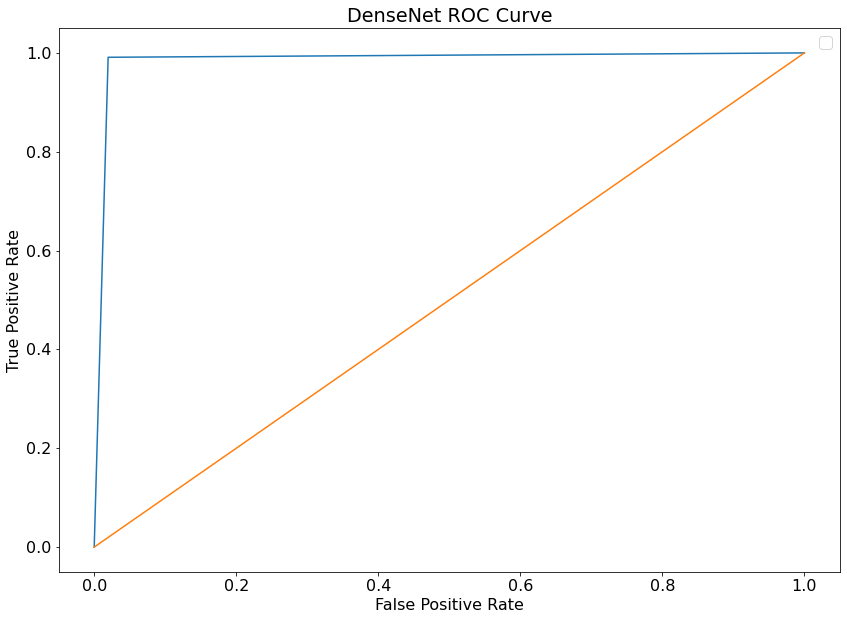

AUC: 0.9857712996703105


In [55]:
#Create ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(14,10))
fpr, tpr, _ = metrics.roc_curve(test_true_labels, test_pred_labels)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DenseNet ROC Curve')
plt.legend()
plt.show()
print("AUC: " + str(roc_auc))

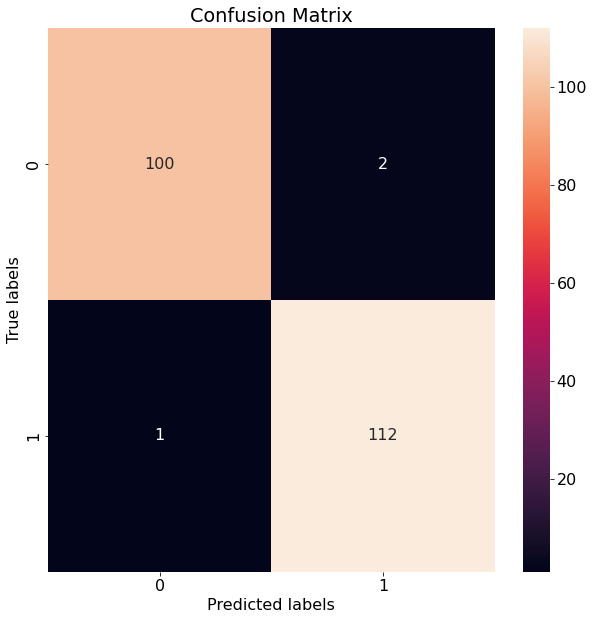

In [56]:
#Confusion Matrix
import seaborn as sns

conf_mat = confusion_matrix(test_true_labels, test_pred_labels)

# Generate a new figure
plt.figure(figsize=(10,10))

# Display the confusion matrix
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [29]:
#Use this to save model
# model.save('(model_name)')

## InceptionV3 Multi-Class Model

In [57]:
### Create multiclass labels df
multiclass_labels_df = pd.DataFrame(multiclass_labels)
multiclass_labels_df.rename(columns = {0:'label'}, inplace=True)

In [58]:
multiclass_labels = multiclass_labels_df["label"]

#convert labels to onehot, ensure type is float32
train_multiclass_labels = tf.keras.utils.to_categorical(multiclass_labels).astype(np.float32)

In [59]:
### Shuffle and partition labeled data
train_images_shuffled, train_multiclass_labels_shuffled = shuffle(images, train_multiclass_labels, random_state = 14)

#--Partition into train/val/mock_test--
val_size = 205
train_size = 724
test_size = 215

train_data = train_images_shuffled[0:train_size, :, :, :]
print(train_data.shape)
train_multiclass_labels = train_multiclass_labels_shuffled[0:train_size,]

val_data = train_images_shuffled[train_size:train_size+val_size, :, :,:]
print(val_data.shape)
val_multiclass_labels = train_multiclass_labels_shuffled[train_size:train_size+val_size,]

test_data = train_images_shuffled[val_size:val_size+test_size, :, :, :]
print(test_data.shape)
test_multiclass_labels = train_multiclass_labels_shuffled[val_size:val_size+test_size,]

(724, 100, 100, 3)
(205, 100, 100, 3)
(215, 100, 100, 3)


In [33]:
print('loading InceptionV3 Model')
base_model = tf.keras.applications.InceptionV3(input_shape=(train_data.shape[1],
                                              train_data.shape[2],3),
                                               include_top=False,
                                               weights='imagenet')
print('done')

base_model.summary()

loading InceptionV3 Model
done
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                        

 batch_normalization_10 (BatchN  (None, 10, 10, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 10, 10, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 10, 10, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 10, 10, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 10, 10, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 10, 10, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 10, 10, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 10, 10, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 4, 4, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 4, 4, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 4, 4, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 4, 4, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 4, 4, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 4, 4, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 4, 4, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 4, 4, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 4, 4, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 4, 4, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 4, 4, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 4, 4, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 4, 4, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 4, 4, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 4, 4, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 4, 4, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 4, 4, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 1, 1, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1, 1, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [34]:
# functions to unfreeze layers
def unfreeze_layers(model, top_n_layers):
    """Makes the top layers of the `base_model` trainable (except batch norm)"""
    # unfreeze the top layers while leaving BatchNorm layers frozen
    for layer in model.layers[-top_n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

def freeze_layers(model, top_n_layers):
    """Makes the top layers of the `base_model` untrainable"""
    # unfreeze the top layers while leaving BatchNorm layers frozen
    for layer in model.layers[-top_n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

# un-freeze all layers
base_model.trainable = True

In [35]:
# Add a global spatial average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#Dropout layer
dropout=tf.keras.layers.Dropout(0.2)

# Add the final classification layer
prediction_layer0 = tf.keras.layers.Dense(3, activation='softmax')

model = model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dropout,
    prediction_layer0
])

# Print summary of model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


In [36]:
# Specify the loss function to use
loss_func = tf.keras.losses.binary_crossentropy

base_learning_rate = 0.0001
opt = tf.keras.optimizers.Adamax(learning_rate=base_learning_rate)

# Compile the model using the specified loss function and optimizer
model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])

In [60]:
# Convert all of our training and validation ('test') data to TensorFlow data
train_images_tf = tf.constant(train_data, dtype=tf.float16)
print(train_images_tf.shape)
test_images_tf = tf.constant(test_data)
print(test_images_tf.shape)

train_labels_tf = tf.constant(train_multiclass_labels, dtype=tf.float16)
print(train_labels_tf.shape)
test_labels_tf = tf.constant(test_multiclass_labels)
print(test_labels_tf.shape)

(724, 100, 100, 3)
(215, 100, 100, 3)
(724, 3)
(215, 3)


In [38]:
import time
# (It will ensure that your training process does not consume all available RAM)
class garbage_collect_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

#reduced lr if training plateaus
def scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 3
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.01)

# Time how long it takes the model to train for these epochs
start_time = time.time()

# Perform the training method
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_images_tf,
                    train_labels_tf,
                    batch_size=64,
                    epochs= 40,
                    verbose=1,
                    validation_data=(val_data, val_multiclass_labels),
                    callbacks = [reduce_lr])
                    #callbacks = [garbage_collect_callback()])

stop_time = time.time()
print("--- %s seconds ---" % (stop_time - start_time))

Epoch 1/40
12/12 [==============================] - 11s 334ms/step - loss: 0.6459 - accuracy: 0.4517 - val_loss: 0.6062 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 2/40
12/12 [==============================] - 1s 72ms/step - loss: 0.5512 - accuracy: 0.6588 - val_loss: 0.5678 - val_accuracy: 0.6293 - lr: 1.0000e-04
Epoch 3/40
12/12 [==============================] - 1s 68ms/step - loss: 0.4911 - accuracy: 0.7251 - val_loss: 0.5594 - val_accuracy: 0.6293 - lr: 1.0000e-04
Epoch 4/40
12/12 [==============================] - 1s 67ms/step - loss: 0.4414 - accuracy: 0.7901 - val_loss: 0.5555 - val_accuracy: 0.6341 - lr: 1.0000e-04
Epoch 5/40
12/12 [==============================] - 1s 66ms/step - loss: 0.3895 - accuracy: 0.8453 - val_loss: 0.5410 - val_accuracy: 0.7073 - lr: 1.0000e-04
Epoch 6/40
12/12 [==============================] - 1s 68ms/step - loss: 0.3602 - accuracy: 0.8522 - val_loss: 0.5302 - val_accuracy: 0.7073 - lr: 1.0000e-04
Epoch 7/40
12/12 [==============================] 

In [61]:
#load model and make sure to reshuffle data and put into tensorflow data

#new_model = tf.keras.models.load_model('(model_name)')

In [62]:
# Predict class of test each test
predictions = model.predict(test_images_tf, verbose=True)

# Convert the predictions and true labels into category numbers
test_true_labels = test_labels_tf.numpy().argmax(axis=1)
test_pred_labels = predictions.argmax(axis=1)

7/7 [==============================] - 2s 50ms/step


In [63]:
#get model acc score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

acc = accuracy_score(test_true_labels, test_pred_labels)
print(f'Model Accuracy: {acc:.2%}')

Model Accuracy: 92.56%


In [64]:
#get auc score
false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()
for i in range(3):  # looping through each of 5 classes and getting false and true positive rates and calculating ROCAUC for each class
  false_positive_rate[i], true_positive_rate[i], _ = metrics.roc_curve(test_labels_tf[:,i], predictions[:,i]) # Because labels are not binary, 
  roc_auc[i] = metrics.auc(false_positive_rate[i], true_positive_rate[i])                                                    # they need to be One Hot Vectors (ex. 2 = [0,0,1,0,0])
                                                                                                                     # prediction_scores are the predicted 'probability'
                                                                                                                     # that the example belongs to each of the 5 classes
false_positive_rate["micro"], true_positive_rate["micro"], _ = metrics.roc_curve(test_labels_tf.numpy().ravel(), predictions.ravel())
roc_auc = metrics.auc(false_positive_rate["micro"], true_positive_rate["micro"]) # micro-averaging averages the ROCAUCs from each class weighted 
                                                                         # according to number of example in that class
   
print(f'roc_auc: {roc_auc:.3f}')

roc_auc: 0.989


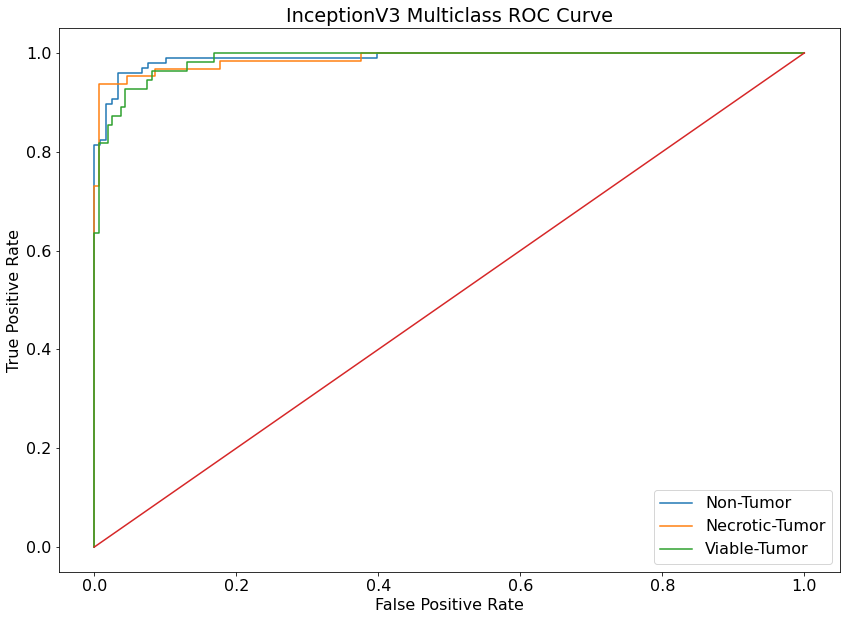

AUC: {0: 0.9900401887122138, 1: 0.987781954887218, 2: 0.9871590909090909}


In [65]:
#create roc curve
false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()
stage_dict = {0:'Non-Tumor', 1:'Necrotic-Tumor', 2:'Viable-Tumor'}

plt.figure(figsize=(14,10))
for i in range(3):
    false_positive_rate[i], true_positive_rate[i], _ = metrics.roc_curve(test_labels_tf[:,i], predictions[:,i]) # Because labels are not binary, 
    roc_auc[i] = metrics.auc(false_positive_rate[i], true_positive_rate[i])     
    plt.plot(false_positive_rate[i], true_positive_rate[i], label = stage_dict[i])
    
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('InceptionV3 Multiclass ROC Curve')
plt.legend()
plt.show()
print("AUC: " + str(roc_auc))

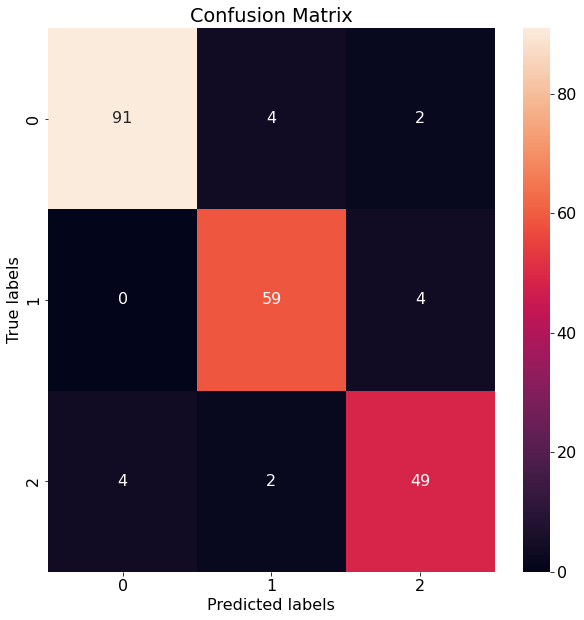

In [66]:
#Create confusion matrix
import seaborn as sns

conf_mat = confusion_matrix(test_true_labels, test_pred_labels)

# Generate a new figure
plt.figure(figsize=(10,10))

# Display the confusion matrix
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [45]:
#Use this to save your model
# model.save('(model_name)')